In [1]:
#Strickland 2024
#Figure 5 graph plotting 
#v1.0 version, this is the first consolidation of analysis done so far
#Requires the environment packages found in 23pubenv

In [2]:
#Basic importing set: 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from scipy.signal import find_peaks
import statsmodels.api as sm

#Image Tools:
from tifffile import TiffFile
from skimage.measure import regionprops as rgnprops

In [3]:
#Lets start by importing the meta dataframe and then pairing them to the wavefile csvs we want to analyze. 

base_path = Path.cwd().parent / Path('Data Sets/2023_01_24_main-set/')
meta_df_path = base_path / 'analysis_DF.csv'
analysis_output_destination = base_path / 'wavefit_outputs'

#There are three important dataframes used in analysis, the wave data frame, the ARCOS df, and the tracking df with binnned calcium values:
#The tracking is the most broad, followed by ARCOS and then the wave (most abstracted info):
wave_dataframe_paths = sorted(analysis_output_destination.glob('*_wave_df.csv'), key=lambda x: x.stem.split('_')[0])
meta_DF = pd.read_csv(meta_df_path)

In [4]:
#To consolodate all the wave dataframes in a set, use the following function: 
#INPUT: Sorted list of all wave dataframe csv locations:
#Option to save the DF as a csv in the relevant location is given, default is False
#OUTPUT: A dataframe containing all of the csv wave DFs in the path list

def consolidate_waves(WAVE_DF_PATHS, save_DF = False):
    
    wave_collect = []

    for wave_df_path in tqdm(WAVE_DF_PATHS):
        img_id = int(wave_df_path.stem.split('_')[0]) #Get the image ID to match to the wave:
        wave_df = pd.read_csv(wave_df_path, converters={"wave_centroid": read_tuple_list}) #Open the wave_DF from step4 analysis
        wave_df = wave_df[wave_df.columns.drop(list(wave_df.filter(regex='Unnamed')))] #Strip it of any weird unnamed index columns
        track_ids = wave_df['clTrackID'].values #Get the collective track values in the wave
        wave_df['wave_ID'] = [str(img_id) + '-' + str(i) for i in track_ids] #Build a list of unique wave IDs from the image number and clTrack number they belong to
        wave_df['image_ID'] = [img_id for i in range(len(wave_df))]
        wave_collect.append(wave_df)
    
    wave_df_collected = pd.concat(wave_collect, ignore_index=True)
    
    if save_DF:
        wave_df_collected.to_csv(WAVE_DF_PATHS[0].parent / 'combined_wave_DF.csv', index=False)
        
    return wave_df_collected

#Custom function to read in centroid arrays into dataframe instead of as a string: 
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [5]:
#Time to introduce and play with the density aspect underlying the waves: 

image_file_loc = base_path / 'images'
seg_file_loc = base_path / 'segmented_nuclei'

px_size = 2.2/1000.0 #um/px --> mm/px

image_list = sorted(image_file_loc.glob('[!.]*.tif'),  key=lambda x: x.stem.split('_')[0])
seg_list = sorted(seg_file_loc.glob('[!.]*.tif'),  key=lambda x: x.stem.split('_')[0])

ca_wave_collect = []



#Lets loop through every wave, get the density at each frame the wave was measured at, and add it to the dataframe:
for im_name, seg_name in tqdm(list(zip(image_list, seg_list))):

    #Get the corresponding segmented nuclei file:

    ca_means = []
    times = []
    target_dfs = []
    nuclei_density = []

    #Loop through the opened segmeneted file, get the max nuclei value (rough total count in frame)
    #Devide by the area of the image itself

    with TiffFile(im_name) as im:
        with TiffFile(seg_name) as seg_im: 
            pages = im.pages
            seg_pages = seg_im.pages
            j = 0
            t = 0

            for page in pages:
                if j%2 == 0:
                    im_pg = page.asarray()
                    ca_m = im_pg.mean()
                    times.append(t)
                    ca_means.append(ca_m)
                    j += 1
                    t += 1
                else:
                    j += 1

            for seg_page in seg_pages:
                seg_pg = seg_page.asarray()
                nuclei = seg_pg.max()
                #nuclei = len(rgnprops(seg_pg)) #yeilds the same number, but much slower to get simple total count!
                mm_sq = (px_size * seg_pg.shape[0]) * (px_size * seg_pg.shape[1])
                nuclei_density.append(nuclei/mm_sq)

    mean_den = np.mean(nuclei_density)
    ca_peaks, _ = find_peaks(ca_means, prominence=1, width=15)

    if len(ca_peaks) == 0:
        continue
    else:
        img_num = int(im_name.stem)
        target_df = pd.DataFrame({'Density':mean_den, 'Ca-peaks':len(ca_peaks)}, index=[img_num])
        ca_wave_collect.append(target_df)

target_ca_DF = pd.concat(ca_wave_collect)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:23<00:00,  2.47it/s]


In [ ]:
#target_ca_DF.to_csv('fig5-supplement-calcium-wave-count-over-density.csv')

In [ ]:
'''
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})
plt.figure(figsize=(5,4))
sns.scatterplot(data = target_ca_DF, x='Density', y='Ca-peaks', s=75, linewidth=2, color='grey', alpha=0.8, legend=False)
sns.regplot(data=target_ca_DF, x='Density', y='Ca-peaks', scatter_kws={'alpha':0}, line_kws={'color':'black', 'linestyle':'--'})
plt.ylabel('')
plt.xlabel('')
plt.savefig('sup-fig4-density-v-wave-number.png', dpi=300, bbox_inches='tight')
'''

'\nsns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, \'font.family\': [\'arial\'], \'axes.linewidth\':2})\nplt.figure(figsize=(5,4))\nsns.scatterplot(data = target_ca_DF, x=\'Density\', y=\'Ca-peaks\', s=75, linewidth=2, color=\'grey\', alpha=0.8, legend=False)\nsns.regplot(data=target_ca_DF, x=\'Density\', y=\'Ca-peaks\', scatter_kws={\'alpha\':0}, line_kws={\'color\':\'black\', \'linestyle\':\'--\'})\nplt.ylabel(\'\')\nplt.xlabel(\'\')\n'

In [ ]:
'''
fit_xs_4numvden = target_ca_DF['Density'].values
fit_xs_4numvden = sm.add_constant(fit_xs_4numvden)
fit_ys_4numvden = target_ca_DF['Ca-peaks'].values
model_4numvden = sm.OLS(fit_ys_4numvden,fit_xs_4numvden)
results_4numvden = model_4numvden.fit()
print(results_4numvden.summary())
'''

"\nfit_xs_4numvden = target_ca_DF['Density'].values\nfit_xs_4numvden = sm.add_constant(fit_xs_4numvden)\nfit_ys_4numvden = target_ca_DF['Ca-peaks'].values\nmodel_4numvden = sm.OLS(fit_ys_4numvden,fit_xs_4numvden)\nresults_4numvden = model_4numvden.fit()\nprint(results_4numvden.summary())\n"

In [6]:
#To consolodate all the wave dataframes in a set, use the following function: 
#INPUT: Sorted list of all wave dataframe csv locations:
#Option to save the DF as a csv in the relevant location is given, default is False
#OUTPUT: A dataframe containing all of the csv wave DFs in the path list

def consolidate_waves(WAVE_DF_PATHS, save_DF = False):
    
    wave_collect = []

    for wave_df_path in tqdm(WAVE_DF_PATHS):
        img_id = int(wave_df_path.stem.split('_')[0]) #Get the image ID to match to the wave:
        wave_df = pd.read_csv(wave_df_path, converters={"wave_centroid": read_tuple_list}) #Open the wave_DF from step4 analysis
        wave_df = wave_df[wave_df.columns.drop(list(wave_df.filter(regex='Unnamed')))] #Strip it of any weird unnamed index columns
        track_ids = wave_df['clTrackID'].values #Get the collective track values in the wave
        wave_df['wave_ID'] = [str(img_id) + '-' + str(i) for i in track_ids] #Build a list of unique wave IDs from the image number and clTrack number they belong to
        wave_df['image_ID'] = [img_id for i in range(len(wave_df))]
        wave_collect.append(wave_df)
    
    wave_df_collected = pd.concat(wave_collect, ignore_index=True)
    
    if save_DF:
        wave_df_collected.to_csv(WAVE_DF_PATHS[0].parent / 'combined_wave_DF.csv', index=False)
        
    return wave_df_collected

#Custom function to read in centroid arrays into dataframe instead of as a string: 
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [7]:
wave_con_df = consolidate_waves(wave_dataframe_paths)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 569.45it/s]


In [8]:
max_radii_groups = wave_con_df.groupby('wave_ID').circle_radius.max()
avg_density_groups = wave_con_df.groupby('wave_ID').cell_density.mean()
avg_den_v_max_radii = pd.merge(max_radii_groups, avg_density_groups, right_index=True, left_index=True)


/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, '')

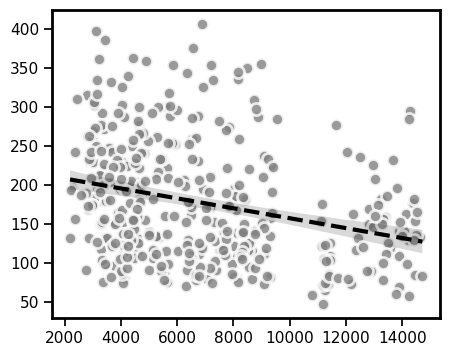

In [11]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})
plt.figure(figsize=(5,4))
sns.scatterplot(data = avg_den_v_max_radii, x='cell_density', y='circle_radius', s=75, linewidth=2, color='grey', alpha=0.8, legend=False)
sns.regplot(data= avg_den_v_max_radii, x='cell_density', y='circle_radius', scatter_kws={'alpha':0}, line_kws={'color':'black', 'linestyle':'--'})
plt.ylabel('')
plt.xlabel('')
#plt.savefig('fig5-density-v-wave-max-radius.png', dpi=300, bbox_inches='tight')

In [12]:
fit_xs_4sizevden = avg_den_v_max_radii['cell_density'].values
fit_xs_4sizevden = sm.add_constant(fit_xs_4sizevden)
fit_ys_4sizevden = avg_den_v_max_radii['circle_radius'].values
model_4sizevden = sm.OLS(fit_ys_4sizevden,fit_xs_4sizevden)
results_4sizevden = model_4sizevden.fit()
print(results_4sizevden.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     34.42
Date:                Fri, 02 Feb 2024   Prob (F-statistic):           9.54e-09
Time:                        14:12:35   Log-Likelihood:                -2220.7
No. Observations:                 389   AIC:                             4445.
Df Residuals:                     387   BIC:                             4453.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        221.2952      8.362     26.463      0.0

In [13]:
represenative_pts = avg_den_v_max_radii.loc[['84-39', '40-14', '78-6']]

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

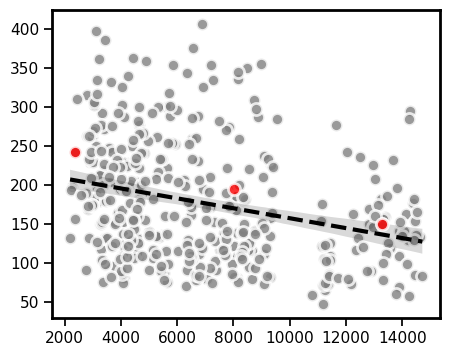

In [14]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})
plt.figure(figsize=(5,4))
sns.scatterplot(data = avg_den_v_max_radii, x='cell_density', y='circle_radius', s=75, linewidth=2, color='grey', alpha=0.8, legend=False)
sns.regplot(data= avg_den_v_max_radii, x='cell_density', y='circle_radius', scatter_kws={'alpha':0}, line_kws={'color':'black', 'linestyle':'--'})
sns.scatterplot(data = represenative_pts, x='cell_density', y='circle_radius', s=75, linewidth=2, color='red', alpha=0.8, legend=False)
plt.ylabel('')
plt.xlabel('')
plt.savefig('fig5-density-v-wave-max-radius.png', dpi=300, bbox_inches='tight')